# NBA PTS Regressor Experiments

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_point_spead_reg as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="whitegrid", palette="husl")

### Utils functions

In [3]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [4]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [5]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.pointplot(data=results_df,
              kind="point", x="season_test", y="rmse", hue="model"
              )
    a.set_title(
        f"{experiment_name}-rmse")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [6]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [7]:
reg_metrics = ['mae', 'mse', 'rmse']

def print_prettier_exp_results(exp_name, metric='rmse'):
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=[f"{metric}_mean"], ascending=True)

## Load Dataset

In [8]:
season_games = sg.load_season_games_dataset()

## EDA

In [25]:
eda_df = season_games

In [26]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21646 entries, 0020200001 to 0021901318
Columns: 178 entries, SEASON_ID to GAME_DATE_EST
dtypes: datetime64[ns](2), float64(126), int64(40), object(10)
memory usage: 29.6+ MB


In [27]:
eda_df.describe()

,TEAM_ID_HOME,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,AST_L10_AWAY,STL_L10_AWAY,BLK_L10_AWAY,TOV_L10_AWAY,PF_L10_AWAY,PTS_L10_AWAY,PLUS_MINUS_L10_AWAY,HOME_WINS,HOME_POINT_SPREAD,SEASON
count,2.164600e+04,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,...,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000,21646.000000
mean,1.610613e+09,241.807493,38.053867,82.732098,0.460948,7.570082,20.996628,0.357365,18.590640,24.485540,...,21.823919,7.577665,4.869551,14.539762,21.102605,100.510239,-0.287958,0.594613,2.969325,2010.457544
std,8.623953e+00,7.583848,5.335071,7.813640,0.056462,3.836670,8.401484,0.115589,6.318934,7.798392,...,2.710392,1.337221,1.181640,1.834785,2.305682,7.678851,6.293498,0.490978,13.191697,5.168496
min,1.610613e+09,240.000000,19.000000,56.000000,0.250000,0.000000,1.000000,0.000000,1.000000,1.000000,...,8.000000,1.000000,0.000000,6.000000,13.900000,59.000000,-33.000000,0.000000,-56.000000,2002.000000
25%,1.610613e+09,240.000000,34.000000,77.000000,0.422000,5.000000,15.000000,0.286000,14.000000,19.000000,...,20.000000,6.700000,4.100000,13.300000,19.500000,95.200000,-4.500000,0.000000,-6.000000,2006.000000
50%,1.610613e+09,240.000000,38.000000,82.000000,0.460000,7.000000,20.000000,0.357000,18.000000,24.000000,...,21.600000,7.500000,4.800000,14.500000,21.000000,100.000000,-0.300000,1.000000,4.000000,2010.000000
75%,1.610613e+09,240.000000,42.000000,88.000000,0.500000,10.000000,26.000000,0.429000,23.000000,29.750000,...,23.500000,8.400000,5.600000,15.700000,22.600000,105.400000,3.900000,1.000000,11.000000,2015.000000
max,1.610613e+09,340.000000,62.000000,125.000000,0.684000,27.000000,70.000000,1.000000,48.000000,64.000000,...,36.000000,16.000000,15.000000,27.000000,42.000000,131.100000,48.000000,1.000000,61.000000,2019.000000


In [29]:
eda_df["WIN"] = ["HOME" if x == 1 else "VISITOR" for x in eda_df['HOME_WINS']]

In [30]:
eda_df["WIN"].value_counts()

HOME       12871
VISITOR     8775
Name: WIN, dtype: int64

### Pandas Profiling

In [ ]:
profile = ProfileReport(eda_df, title='Pandas Profiling Report', pool_size=4,
                        minimal=True,
                        explorative=True,
                           correlations={
             "pearson": {"calculate": True},
             "spearman": {"calculate": True},
             "kendall": {"calculate": True},
             "phi_k": {"calculate": False},
             "cramers": {"calculate": False},
         })
profile.to_file("season_games_pd_report.html")

### By Team

In [32]:
last_season = eda_df[eda_df.SEASON == 2018]
last_season.head()

,SEASON_ID,TEAM_ID_HOME,TEAM_ABBREVIATION_HOME,TEAM_NAME_HOME,GAME_DATE,MATCHUP_HOME,WL_HOME,MIN_HOME,FGM_HOME,FGA_HOME,...,BLK_L10_AWAY,TOV_L10_AWAY,PF_L10_AWAY,PTS_L10_AWAY,PLUS_MINUS_L10_AWAY,HOME_WINS,HOME_POINT_SPREAD,SEASON,GAME_DATE_EST,WIN
GAME_ID,,,,,,,,,,,,,,,,,,,,,
0021800001,22018,1610612738,BOS,Boston Celtics,2018-10-16,BOS vs. PHI,W,240,42,97,...,5.0,16.0,20.0,87.0,-18.0,1,18,2018,2018-10-16,HOME
0021800002,22018,1610612744,GSW,Golden State Warriors,2018-10-16,GSW vs. OKC,W,240,42,95,...,6.0,15.0,21.0,100.0,-8.0,1,8,2018,2018-10-16,HOME
0021800003,22018,1610612766,CHA,Charlotte Hornets,2018-10-17,CHA vs. MIL,L,240,41,92,...,4.0,21.0,25.0,113.0,1.0,0,-1,2018,2018-10-17,VISITOR
0021800004,22018,1610612765,DET,Detroit Pistons,2018-10-17,DET vs. BKN,W,240,39,92,...,5.0,19.0,23.0,100.0,-3.0,1,3,2018,2018-10-17,HOME
0021800005,22018,1610612754,IND,Indiana Pacers,2018-10-17,IND vs. MEM,W,240,47,83,...,3.0,10.0,18.0,83.0,-28.0,1,28,2018,2018-10-17,HOME


In [33]:
home_wins_df = last_season[["HOME_TEAM_NAME", "HOME_TEAM_WINS"]].groupby(by="HOME_TEAM_NAME") \
.agg({'HOME_TEAM_NAME':'count', 'HOME_TEAM_WINS': 'sum'}) \
.sort_values(by=["HOME_TEAM_WINS"], ascending=False)
home_wins_df["TEAM_LOSS"] = home_wins_df["HOME_TEAM_NAME"] - home_wins_df["HOME_TEAM_WINS"]
home_wins_df.drop(labels=["HOME_TEAM_NAME"], axis=1, inplace=True)
home_wins_df.rename(columns={"HOME_TEAM_WINS": "TEAM_WINS"}, inplace=True)
home_wins_df.index.rename("TEAM_NAME", inplace=True)
home_wins_df

KeyError: "None of [Index(['HOME_TEAM_NAME', 'HOME_TEAM_WINS'], dtype='object')] are in the [columns]"

In [34]:
visitor_wins_df = last_season[["VISITOR_TEAM_NAME", "HOME_TEAM_WINS"]].groupby(by="VISITOR_TEAM_NAME") \
.agg({'VISITOR_TEAM_NAME':'count', 'HOME_TEAM_WINS': 'sum'}) \
.sort_values(by=["HOME_TEAM_WINS"], ascending=False)
visitor_wins_df["TEAM_WINS"] = visitor_wins_df["VISITOR_TEAM_NAME"] - visitor_wins_df["HOME_TEAM_WINS"]
visitor_wins_df.rename(columns={"HOME_TEAM_WINS": "TEAM_LOSS"}, inplace=True)
visitor_wins_df.drop(labels=["VISITOR_TEAM_NAME"], axis=1, inplace=True)
visitor_wins_df.index.rename("TEAM_NAME", inplace=True)
#visitor_wins_df = visitor_wins_df[["TEAM_WINS"]]
visitor_wins_df = visitor_wins_df[["TEAM_WINS", "TEAM_LOSS"]]
visitor_wins_df

KeyError: "None of [Index(['VISITOR_TEAM_NAME', 'HOME_TEAM_WINS'], dtype='object')] are in the [columns]"

In [35]:
home_wins_df.combine(visitor_wins_df, lambda s1, s2: s1 + s2).sort_values(by="TEAM_WINS", ascending=False)

NameError: name 'home_wins_df' is not defined

In [36]:
mil_df = last_season[(last_season.VISITOR_TEAM_NAME == 'MIL') | (last_season.HOME_TEAM_NAME == 'MIL')]
mil_df['GAME_N'] = range(1, 83,1)
mil_df

AttributeError: 'DataFrame' object has no attribute 'VISITOR_TEAM_NAME'

In [37]:
#sns.regplot(x=mil_df["GAME_N"], y=mil_df["GAME_N"])
#sns.catplot(data=mil_df[["HOME_TEAM_NAME", "GAME_N", "WIN"]],  x="GAME_N", y="HOME_TEAM_NAME", kind="bar", hue="WIN", palette="Set2")
#sns.displot(data=mil_df, x="GAME_N", hue="WIN", multiple="stack")
#plt.show()


### Scatter plot

## Dataset


In [38]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [9]:
df = season_games[season_games.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

## Experiments

### Setup

In [11]:
exp_prefix = ""
exp_group_name = "reg_experiments"
results_total = []
utils_exp.exp_results = []
TARGET = "PTS"
exp_X_columns = model_config.X_COLS
exp_y_columns = model_config.Y_CLF_COL


models = utils_exp.get_reg_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

#utils_exp.exp_results = utils.deserialize_object(exp_group_name)

### Experiment using 1 season

In [12]:
experiment_name = f"{exp_prefix}1_season"
#del_exp_result(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 1_season
Done


,exp_name,model,rmse_mean,rmse_std
0,1_season,LinearRegression,16.363950,0.431022
3,1_season,SVM-linear,17.258884,0.497453
4,1_season,RF,17.661414,0.476695
5,1_season,LGB,17.777755,0.452947
1,1_season,KN,19.203184,0.551122
6,1_season,XGB,19.521376,0.888771
2,1_season,SVM-rbf,20.151353,1.071520


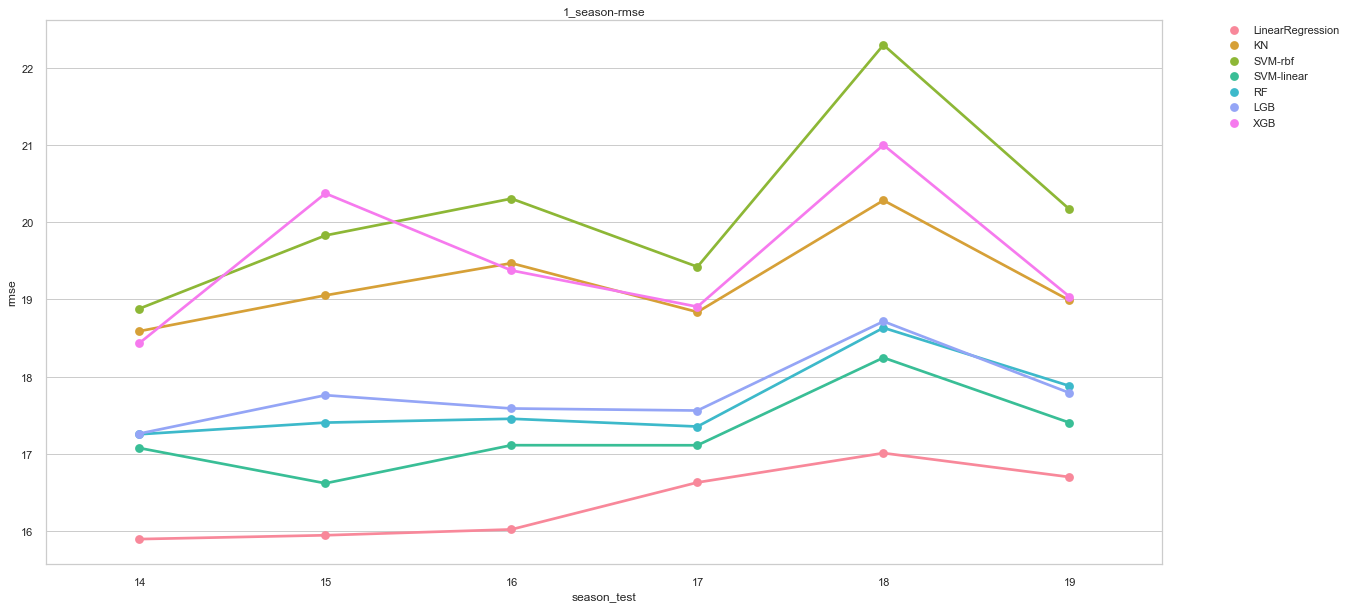

In [13]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

### Experiment using StandardScaler

In [14]:
experiment_name = f"{exp_prefix}scaled_data"

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment scaled_data
Done


,exp_name,model,rmse_mean,rmse_std
7,scaled_data,LinearRegression,16.356037,0.439171
10,scaled_data,SVM-linear,16.415914,0.534536
9,scaled_data,SVM-rbf,17.326927,0.502268
11,scaled_data,RF,17.664305,0.487005
12,scaled_data,LGB,17.859179,0.409615
8,scaled_data,KN,18.925808,0.805558
13,scaled_data,XGB,19.663209,0.596575


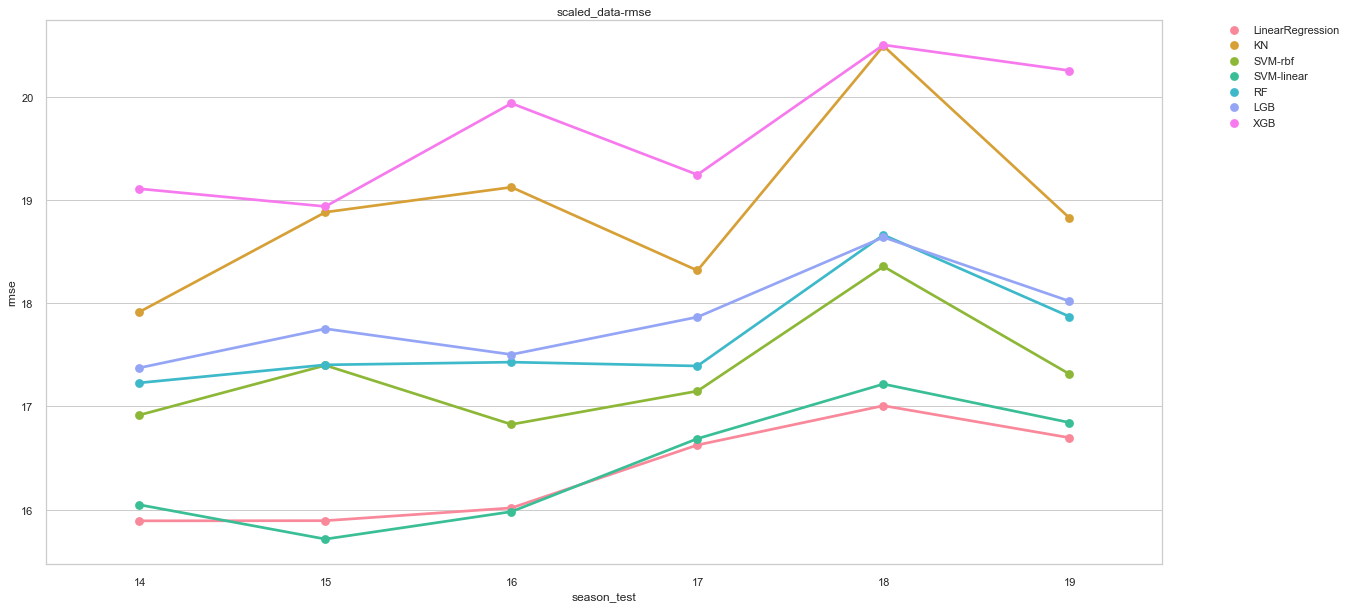

In [15]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment using MinMaxScaler

In [16]:
experiment_name = f"{exp_prefix}minmax_data"

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, model_config.X_COLS)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment minmax_data
Done


,exp_name,model,rmse_mean,rmse_std
17,minmax_data,SVM-linear,16.318015,0.457154
14,minmax_data,LinearRegression,16.363272,0.430018
16,minmax_data,SVM-rbf,17.113430,0.486605
18,minmax_data,RF,17.666607,0.487552
19,minmax_data,LGB,17.848965,0.537793
15,minmax_data,KN,19.039720,0.853401
20,minmax_data,XGB,19.668643,0.599296


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***XGB***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***RF***: Obtuvo el segundo promedio mas alto.
    - ***LGB***: Obtuvo el tercer promedio mas alto.

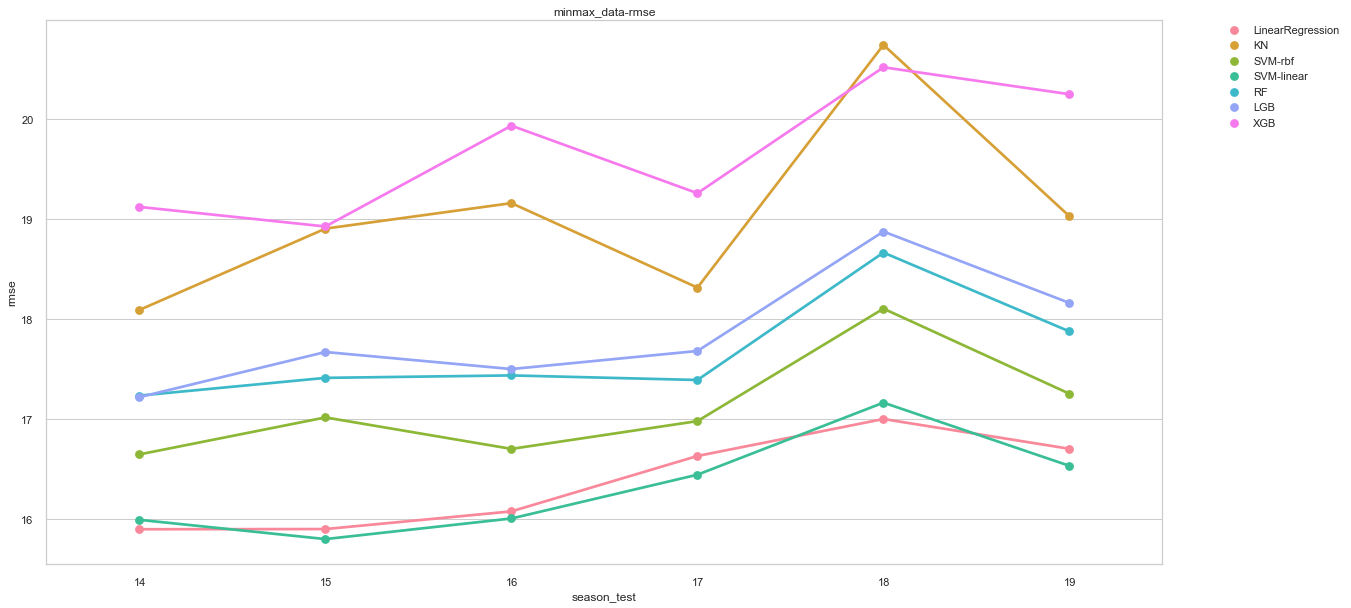

In [17]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - A pesar de que obtuvo el mejor rendimiento en la primera validacion, el algoritmo SVM empeoro en cada validacion. Cabe señalar tambien que ademas de que cayo empicado arrojo un rendimiento de un 50% para la ultima validacion.
    - Para los demas algoritmos se evidencia un patron en la validacion de predecir al temporada 15 donde para todos fue un mejor rendimiento que para predecir la temporada 14.
    - Para la temporada 16 el rendimiento bajo para todos.
    - Para la temporada 17 el algoritmo KNN presenta una notable mejoria por enciman de los demas algoritmos.
    - Para la ultima temporada el algoritmo XGB fue el que obtuvo el mejor rendimiento.

### Experiment: train: 2s; test: 1s

In [ ]:
experiment_name = f"{exp_prefix}2_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 2_seasons


- Respecto a la metrica balanced_accuracy se observa lo siguiente:

    - ***SVM***: Fue el algoritmo que alcanzo el mejor promedio.
    - ***LGB***: Obtuvo el segundo promedio mas alto.
    - ***XGB***: Obtuvo el tercer promedio mas alto.

In [ ]:
plot_results(experiment_name, results, figsize=(20,10))

En el grafico de los resultados del experimento se observa lo siguiente:

    - Claramente SVM fue el algoritmo que mejor rendimiento tuvo en cada una de las validaciones.
    - Se evidencia un patron en el que todos los algoritmos tuvieron una caida de su rendimiento en la temporada 16 y continuo cayendo en el 17, a excepcion de RF que mejoro.
    - Otro patron que se evidencia es que para la temporada 2018 todos los algoritmos mejoraron.


### Experiment: train: 3s; test: 1s

In [ ]:
experiment_name = f"{exp_prefix}3_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

In [ ]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment train: 3q ; test: 1q

In [ ]:
experiment_name = f"{exp_prefix}3q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

In [ ]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment train: 4q ; test: 2q

In [ ]:
experiment_name = f"{exp_prefix}4q_2q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

In [ ]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [ ]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

In [ ]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

### Experiments comparison

In [ ]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [ ]:
exp_df = get_results_df()

In [ ]:
ba_df = exp_df[['exp_name', 'model',
       'rmse_mean', 'rmse_std']]

In [ ]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(ba_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

In [ ]:
ba_df.sort_values(
    by=["rmse_mean"]
    , ascending=True)[:6].reset_index().drop(labels=["index"], axis=1)

### Plot experiment results

In [ ]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### MAE

In [ ]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mae",
    figsize=(25, 35),
    use_pointplot=True
)

#### MSE

In [ ]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mse",
    figsize=(25, 35),
    use_pointplot=True
)

#### RMSE

In [ ]:
utils.plot_to_compare_experiments(
    results_total,
    metric="rmse",
    figsize=(25, 35),
    use_pointplot=True
)